In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/saved_model.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/keras_metadata.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/assets/vocab.txt
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/variables/variables.index
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2/variables/variables.data-00000-of-00001
/kaggle/input/d/mruanova/emojify/tesss.csv
/kaggle/input/d/mruanova/emojify/emojify_data.csv
/kaggle/input/d/mruanova/emojify/train_emoji.csv
/kaggle/input/d/mruanova/emojif

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import emoji

# from transformers import AutoTokenizer, TFBertModel
import tensorflow as tf
from transformers.tokenization_utils_base import BatchEncoding
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout,Activation,Input

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from IPython.display import clear_output

In [3]:
def progress(cnt,y):
    if not cnt % 300:
        clear_output(wait=True)
        progress = cnt * 100 / y

        print("\033[92m━\033[0m"*int(progress/1.7),end="")
        print("-"*int((100 - progress)/1.7),end="")
        print(f" \033[92m{progress:.2f}%\033[0m")

In [4]:
emoji_dictionary = {
    "0": "\U0001F496",      # 💖
    "1": ":baseball:",      # ⚾
    "2": ":smile:",         # 😄
    "3": ":disappointed:",  # 😞
    "4": ":fork_and_knife:" # 🍴
}

# ***Emojify***
___

## I. Data

In [5]:
!pwd

/kaggle/working


In [6]:
data = pd.read_csv("/kaggle/input/d/mruanova/emojify/emojify_data.csv",names=["txt","emoji","null","null2"])
data = data.drop(["null","null2"],axis=1)
data.head()

,txt,emoji
0,French macaroon is so tasty,4
1,work is horrible,3
2,I am upset,3
3,throw the ball,1
4,Good joke,2


<Axes: >

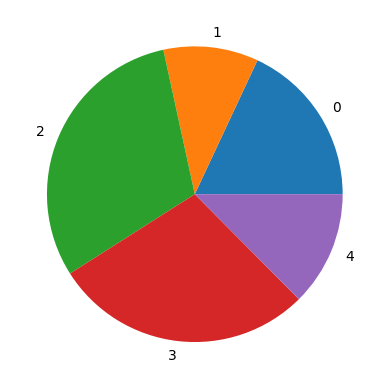

In [7]:
data.groupby("emoji").size().plot(kind="pie")

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   txt     183 non-null    object
 1   emoji   183 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [9]:
seq_length = len(max(data["txt"],key = len).split())
seq_length

10

# BERT

In [10]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [15]:
bert_tokenizer = hub.KerasLayer(tfhub_handle_preprocess)

In [23]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_tokenizer(text_test)

print(f'\033[93mKeys       :\033[0m {list(text_preprocessed.keys())}')
print(f'\033[93mShape      :\033[0m {text_preprocessed["input_word_ids"].shape}')
print(f'\033[93mWord Ids   :\033[0m {text_preprocessed["input_word_ids"][0, :12]}')
print(f'\033[93mInput Mask :\033[0m {text_preprocessed["input_mask"][0, :12]}')
print(f'\033[93mType Ids   :\033[0m {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
bert = hub.KerasLayer(tfhub_handle_encoder)

In [22]:
bert_results = bert(text_preprocessed)

print(f'\033[93mLoaded BERT:\033[0m {tfhub_handle_encoder}')
print(f'\033[93mPooled Outputs Shape:\033[0m{bert_results["pooled_output"].shape}')
print(f'\033[93mPooled Outputs Values:\033[0m{bert_results["pooled_output"][0, :12]}')
print(f'\033[93mSequence Outputs Shape:\033[0m{bert_results["sequence_output"].shape}')
print(f'\033[93mSequence Outputs Values:\033[0m{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


In [25]:
def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(10, activation="relu", name='Dense_layer')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation="softmax", name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [27]:
my_model = build_model()

In [29]:
bert_raw_result = my_model(tf.constant(text_test))

In [30]:
bert_raw_result

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.30940196, 0.04746003, 0.4273007 , 0.08865208, 0.12718533]],
      dtype=float32)>

## II.03 Split data : 

In [ ]:
np.array(data["emoji"]).reshape(183,1 )

In [ ]:
OHE = OneHotEncoder()
y = OHE.fit_transform(np.array(data["emoji"]).reshape(183,1)).toarray()
y.shape

In [ ]:
y[:2]

In [ ]:
X_train , X_test ,y_train , y_test = train_test_split(tokenized,y,test_size=.2)

In [ ]:
 y_train.shape , y_test.shape

# II. Model : 

In [ ]:
max_len = 15
bert = TFBertModel.from_pretrained("google-bert/bert-base-uncased")

In [ ]:
txt = "hi , my name is"
# out = tokenizer(txt ,max_length=20,padding=True,return_tensors="tf" )
out = tokenized[0]
out = bert(out)
out = outputs.last_hidden_state

In [ ]:
txt = "hi , my name is"
# out = tokenizer(txt ,max_length=20,padding=True,return_tensors="tf" )
tkn = tokenizer(txt,padding=True,return_tensors="np")
out = bert(tkn)
out = outputs.last_hidden_state

In [ ]:
tkn

In [ ]:
txt

In [ ]:
##### input_ids = Input(shape=(1, 10),dtype=tf.int32, name='input_ids')
# input_ids = tf.convert_to_tensor(input_ids)

# attention_mask = Input(shape=(1, 10),dtype=tf.int32, name='attention_mask')
# attention_mask = tf.convert_to_tensor(attention_mask)


txt = tf.keras.Input(shape=())
out = BatchEncoding(txt)
out = bert(out)
out = outputs.last_hidden_state

out = GlobalMaxPool1D()(out)
out = Dense(20,"relu")(out)
out = Dropout(0.5)(out)
out = Dense(5)(out)
out = Activation('softmax')

model = tf.keras.Model(inputs=txt, outputs=out)
# model.layers[2].trainable = True

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early_stopping_acc = EarlyStopping(monitor='val_accuracy',min_delta=0.0001, patience=1, restore_best_weights=True)
# early_stopping_loss = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=1, restore_best_weights=True)

history = model.fit(X_train,y_train,epochs=9, validation_data=(X_test, y_test)) #, callbacks=[early_stopping_acc,early_stopping_loss]

In [ ]:
history_2 = model.fit(X_train,y_train,epochs=1, validation_data=(X_test, y_test))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].legend(['accuracy', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['loss', 'val_loss'], loc='upper left')

plt.show()

# III. Predect 

In [ ]:
def pred(txt):
    tokenized = word_tokenize(str(txt).lower())
    word_vec = word_tokenizer.texts_to_sequences(tokenized)
    for i in range(len(word_vec)):
        if not word_vec[i]:
            word_vec[i] = [0]
    word_vec_pad = pad_sequences([word_vec],padding='post')
    p = model.predict(word_vec_pad)   
    print(f"{txt}",' '*(40-len(txt)),"|",emoji.emojize(emoji_dictionary[f"{list(p[0]).index(p[0].max())}"],language='alias'))

In [ ]:
sents = ["I Love you...",
    "I am proud of your achievements",
    "I am so sad", 
    "French macaroon is so tasty",
]

for s in sents:
      pred(s)  

# IV. Summary: 
#### *It was a generally successful experience, despite facing overfitting issues due to the very small data size.*

In [ ]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf

# Load the model and tokenizer
model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input text
text = "This is a test sentence."
inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True, max_length=512)

# Pass inputs through the model
outputs = model(inputs)

# Get the last hidden states
last_hidden_states = outputs.last_hidden_state

# Print the shape of the output (batch_size, sequence_length, hidden_size)
print(last_hidden_states.shape)
